## Flexure profile solver for an unfixed grounding line

<b>Translation of the Matlab script into Python</b>

<b>Imports</b>

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
import pandas as pd
import math
np.math = math

In [27]:
from Flexure_solver import Flexure_profile_unfixed_grounding_line

In [28]:
def ice_profile(x, s, b, zm, h, b0, dzm_dh, lgd_flag, str_title):
    line_width = 1.5
    # Create figure and set its size
    fig = plt.figure(figsize=(12, 6))  # Equivalent to MATLAB's Position [200, 100, 1200, 600]

    # Set up tiled layout (using gridspec for control)
    gs = fig.add_gridspec(4, 1, hspace=0.4)
    # Main plot (3-row span)
    ax_main = fig.add_subplot(gs[:3, 0])
    ax_main.axhline(0, color='k', linestyle=':', label='Sea level')  # Sea level line
    ax_main.plot(x, -b, '-', color='#A9561E', linewidth=line_width, label='Compressed bed')
    ax_main.plot(x, -b0, '--', color='#A9561E', linewidth=line_width, label='Uncompressed bed')
    ax_main.fill_between(x, -b0, -5, color='#A9561E', alpha=0.3, interpolate=True)
    ax_main.plot(x, s, '-', color='b', linewidth=line_width, label='Surface')
    ax_main.plot(x, zm, 'k--', linewidth=line_width, label='$z_{m}$')
    ax_main.plot(x, zm - h/2, 'k-.', linewidth=line_width, label='$z_{m} - h/2$')
    ax_main.plot(x, zm + h/2, 'k-.', linewidth=line_width, label='$z_{m} + h/2$')
    ax_main.fill_between(x, zm + h/2, zm - h/2, color='#7DF9FF', alpha=0.3, interpolate=True)
    ax_main.fill_between(x, zm - h/2, -b0, where=((zm - h/2) > -b0), color='C0', alpha=0.4, interpolate=True)
    ax_main.set_xlabel(f'x (m)', fontsize=16, labelpad=10)
    ax_main.set_ylabel(f'z (m)', fontsize=16, labelpad=10)

    ax_main.set_title(str_title, fontsize=18)
    ax_main.set_xlim(-10, 5)
    ax_main.set_ylim(-5, 5)

    # Add legend if requested
    if lgd_flag == 1:
        ax_main.legend(fontsize=14, loc='center left', title_fontsize=14, title="Legend", bbox_to_anchor=(1, 0.5))

    # Secondary plot for thickness h (1-row span)
    ax_h = fig.add_subplot(gs[3, 0])
    ax_h.axhline(0, color='k', linestyle=':')
    ax_h.plot(x, h, 'r.-', linewidth=line_width, label='Ice thickness')
    ax_h.set_xlabel(f'x (m)', fontsize=16, labelpad=10)
    ax_h.set_ylabel(f'h (m)', fontsize=12, labelpad=10)
    ax_h.grid(True)
    ax_h.boxplot = True
    ax_h.set_ylim(0, 1.4)

    # ax_dh = fig.add_subplot(gs[4, 0])
    # # ax_dh.axhline(0, color='k', linestyle=':')
    # ax_dh.plot(x, h - 1, 'b.-', linewidth=line_width, label='Ice thickness')
    # ax_dh.set_xlabel(f'x (m)', fontsize=16, labelpad=10)
    # ax_dh.set_ylabel(f'h - H (m)', fontsize=8, labelpad=10)
    # ax_dh.grid(True)
    # ax_dh.boxplot = True
    # ax_dh.set_ylim(-0.4, 1.1)

    # ax_newt = fig.add_subplot(gs[5, 0])
    # ax_newt.axhline(0, color='k', linestyle=':')
    # ax_newt.plot(x, dzm_dh + 1/2, 'b.-', linewidth=line_width, label='Ice thickness')
    # ax_newt.set_xlabel(f'x (m)', fontsize=16, labelpad=10)
    # ax_newt.set_ylabel(r'$\frac{dz_m}{dh}$ + $\frac{1}{2}$', fontsize=8, labelpad=10)
    # ax_newt.grid(True)
    # ax_newt.boxplot = True
    # ax_newt.set_ylim(-0.2, 1.3)

    plt.tight_layout()
    plt.show()

    return

/var/folders/yh/jv903ppx44b04y7xxkd39x3w0000gn/T/ipykernel_29844/4028555671.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


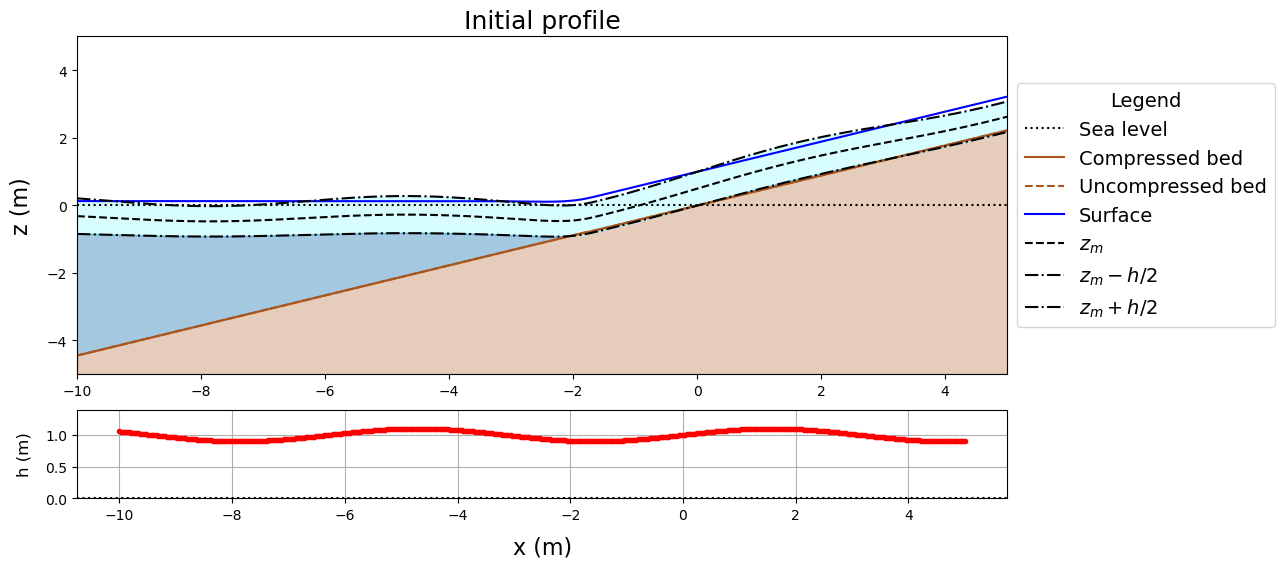

In [29]:
# Initialisation

Nx = 500
xmin = -10
xmax = 5
x = np.linspace(xmin, xmax, Nx)

# base_angle = 3 * np.pi / 180
# base_angle = 24 * np.pi / 180
base_angle = 24 * np.pi / 180

Slope = np.tan(base_angle)
b = -Slope * x

# Parameters

E_ice = 1e3  # 1e2  # 9e9  # Pa
nu_ice = 0.3
rho_w = 1e3  # (kg m^-3)
rho_i = 0.8788 * rho_w  # (kg m^-3) - based on Thwaites data
g = 9.81  # (m s^-2)

# k0 = 1e1 * rho_i * g #(Pa/m)
k0 = 1e2 * rho_i * g #(Pa/m)
# k0 = 1e3 * rho_i * g #(Pa/m)
# k0 = 1e4 * rho_i * g #(Pa/m)
# k0 = 1e5 * rho_i * g #(Pa/m)
# k0 = 1e8 * rho_i * g #(Pa/m)

gamma_val = E_ice / (12 * (1 - nu_ice**2))  # (Pa)


# Coefficients for use in ODE below
C1 = gamma_val / (rho_w * g)  # (m)
C2 = k0 / (rho_w * g)
C3 = rho_i / rho_w

# Ice Thickness
H = 1
# h = np.ones(len(H))

# Bending Stress
B = E_ice * H**3 / (12 * (1 - nu_ice**2))

# Analytical solution

u = -x

# Bending-buoyancy length scale
L = (B / (rho_w * g))**(1/4)

# Grounded region
gamma_0 = 1 / np.sqrt(2) * (k0/B)**(1/4)

# Floating region
gamma_1 = 1 / (np.sqrt(2) * L)

ug = (H / Slope) * (rho_i / rho_w) * (1 + (rho_w * g / k0)**(1 / 2)) - (np.sqrt(2) * L / (1 + (rho_w * g / k0)**(1 / 4)))

za_0 = (1 / 2) - (rho_i * g / k0) - (Slope * u / H) + \
    np.exp(gamma_0 * (u - ug)) * (
        np.cos(gamma_0 * (u - ug)) * (rho_i * g / k0) +
        np.sin(gamma_0 * (u - ug)) * (1 + gamma_1 / gamma_0)**(-1) *
        ((rho_i * g / k0) + (gamma_1 / gamma_0)**3 *
         (rho_i / rho_w - (Slope * ug / H))))

za_1 = (1 / 2) - (rho_i / rho_w) + \
    np.exp(-gamma_1 * (u - ug)) * (
        np.cos(gamma_1 * (u - ug)) * (rho_i / rho_w - (Slope * ug / H)) -
        np.sin(gamma_1 * (u - ug)) * (1 + gamma_1 / gamma_0)**(-1) *
        ((rho_i * g / k0) * (gamma_1 / gamma_0)**(-2) +
         (gamma_1 / gamma_0) * (rho_i / rho_w - (Slope * ug / H))))

za = np.zeros_like(u)
za[u <= ug] = za_0[u <= ug]
za[u > ug] = za_1[u > ug]

# Target surface profile
s = za + H/2
f = -(za - H/2)

# Initial profiles
# noise = 0.05 * np.random.normal(0, 1, Nx)

# h_init = np.ones(Nx) * H 
h_init = np.ones(Nx) * H + 0.1 * np.sin(x)
# h_init = np.ones(Nx) * 1.2 * H
# h_init = np.ones(Nx) * 2 * H

# Initial midline profile - assumed to be lying along the bed
# zm_init = -b + h_init/2

zm_init = za + 0.1 * np.sin(x)
# zm_init = np.zeros(Nx) 

# zm_init = np.zeros_like(Nx)

# zm_data = (s-b)/2
# h_data = (s+b)

# zm_data = (s-f)/2
# h_data = (s+f)

# ####
# h_init = s + b
# h_init[:len(f[~np.isnan(f)])] = s[:len(f[~np.isnan(f)])].copy() + f[:len(f[~np.isnan(f)])].copy()


# heighest_point_idx = int(Nx/2)   #np.argmin(b)
# zm_init = -b.copy() + (h_init.copy()/2)
# zm_init[:heighest_point_idx - 1] = zm_init[heighest_point_idx]
# # zm_init[:62] = zm_init[62]
# ####

zm_data = za
h_data = H * np.ones_like(s)


b_data = np.fmax(b, -(za - H/2))
b0_init = b_data.copy()

# # Pre-allocate arrays
h = h_init.copy()
b0 = b0_init.copy()
h_update = h.copy()
b0_update = b0.copy()

# Pre-allocate arrays

dzm_dh = np.zeros_like(h)
dzm_db0 = np.zeros_like(h)


lgd_flag = 1
str_title = f'Initial profile'
ice_profile(x, s, b_data, zm_init, h_init, b0_init, dzm_dh, lgd_flag, str_title)

In [30]:
# h = np.ones(Nx) * H

# zm = 0

# zm, dzm_dh, dzm_db0 = Flexure_profile_unfixed_grounding_line(zm_init,h_init,b0_init,x,C1,C2,C3)

# ice_profile(x, s, b, zm, h, b0, dzm_dh, lgd_flag, str_title)

In [31]:
def contiguous_regions(v):

    v = np.asarray(v).astype(int)  # Convert boolean to integer (0 or 1)
    N = len(v)
    
    d = np.diff(np.sign(v))  # Difference between consecutive elements

    # Identify the start indices of regions where v > 0
    idxs_start = np.where(d > 0)[0] + 1
    if v[0] > 0:
        idxs_start = np.insert(idxs_start, 0, 0)

    # Identify the end indices of regions where v > 0
    idxs_end = np.where(d < 0)[0]
    if v[-1] > 0:
        idxs_end = np.append(idxs_end, N - 1)

    # Combine start and end indices
    idxs = np.column_stack((idxs_start, idxs_end))
    
    return idxs

In [33]:
def update_profile(p_init, df_dp, f, f_data, p_data, v_change, omega):
    
    # Calculate the Newton-Raphson update
    p_update = p_init - ((f - f_data) / df_dp)

    # Apply updates only where allowed; otherwise, use known data
    p_update[~v_change] = p_data[~v_change]

    # Apply a fraction (omega) of the Newton-Raphson step
    p_new = np.copy(p_data)
    p_new[v_change] = p_init[v_change] + omega * (p_update[v_change] - p_init[v_change])

    return p_new, p_update

In [34]:
def finalplots(idxs_gr, idxs_flt, zm, b0, x):

    fig, ax = plt.subplots(figsize=(15, 8), tight_layout=True)

    ax.axvline(-ug, color='k', linestyle='--', alpha=0.1)  # xline
    ax.axvline(-ug, color='k', linestyle='--', alpha=0.1)
    ax.axhline(0, color='k', linestyle=':') 

    for start, end in idxs_gr:
        ax.fill_between(x[start:end], -b[start:end], zm[start:end]+h[start:end]/2, interpolate=True, facecolor='b', alpha=0.15)

    # Submerged regions (uncomment if required)
    # for start, end in idxs_sb:
    #     ax.fill_betweenx([min(-b), max(zm + h / 2)], x[start], x[end], facecolor='r', alpha=0.05)

    # Floating regions
    for start, end in idxs_flt:
        ax.fill_between(x[start:end], -b[start:end], zm[start:end]+h[start:end]/2, interpolate=True, facecolor='g', alpha=0.15)

    # Plot main profiles
    handle_za, = ax.plot(x, za, 'm-', linewidth=1.5, label='Analytical solution')
    ax.plot(x, za - H / 2, 'm')  # Analytical bounds
    ax.plot(x, za + H / 2, 'm')

    handle_zm, = ax.plot(x, zm, 'b--', linewidth=1.5, label='Numerical solution')
    ax.plot(x, zm - h / 2, 'b:')  # Numerical bounds
    ax.plot(x, zm + h / 2, 'b:')

    handle_b, = ax.plot(x, -b, 'r-', label='Bed topography')
    ax.plot(x, -b0, 'r--', label='Bed topography')


    # Final plot settings
    ax.set_box_aspect(1/3)  # Box on equivalent
    ax.set_xlabel(f'$x$ (m)', fontsize=16)
    ax.set_ylabel(f'$z$ (m)', fontsize=16)
    ax.set_xlim(-10, 5)
    ax.set_ylim(-3, 3)

    # ax.set_xlim(-3, 0)
    # ax.set_ylim(-2, 2)

    ax.set_title(f"S = tan({(base_angle * (180 / np.pi)):.2g}{u'\N{DEGREE SIGN}'}), E = {E_ice:.2g}Pa, $k_i$/$\\rho_i$g = {(k0 / (rho_i * g)):.2g}, Nx = {Nx}", fontsize=20, pad=20)

    # Legend
    ax.legend(handles=[handle_b, handle_zm, handle_za], fontsize=14, loc='lower center', ncol=3, bbox_to_anchor=[0.5, -0.4])

    '''
    # Inset - Grounding-line region
    inset_ax = fig.add_axes([0.7, 0.4, 0.25, 0.2])  # Equivalent to 'Position',[0.6,0.25,0.25,0.2]
    inset_ax.axvline(-ug, color='k', linestyle='--')
    inset_ax.axhline(0, color='k', linewidth=0.5)

    # Inset profiles
    inset_ax.plot(x, za, 'm-', linewidth=1.5)
    inset_ax.plot(x, za - h / 2, 'm')
    inset_ax.plot(x, za + h / 2, 'm')
    inset_ax.plot(x, zm, 'b--', linewidth=1.5)
    inset_ax.plot(x, zm - h / 2, 'b:')
    inset_ax.plot(x, zm + h / 2, 'b:')
    inset_ax.plot(x, -b, 'r-')

    # Final inset settings
    inset_ax.set_xlim(-ug + L * np.array([-6, 6]))
    inset_ax.set_ylim(-1.5, 1.5)  # Uncomment if needed
    inset_ax.set_box_aspect(1/2)

    plt.show()
    '''

    fig, axs = plt.subplot_mosaic([[0],[1]], figsize=(10, 8), constrained_layout=True, sharex=True)
    fig.suptitle("Error in ice sheet-shelf profile", fontsize=18, fontweight='bold')

    ax = axs[0]
    ax.plot(x, zm - za, 'k-', linewidth=1.5, label=r'Error in centreline ($z_m$-$z_a$)')
    # ax.set_xlabel(f'$x$ (m)', fontsize=16)
    ax.set_ylabel(f'$z$ (m)', fontsize=16)
    # ax.set_xlim(-40, 40)
    # ax.set_title('Error in ice centreline profile produced by numerical solver', fontsize=16)
    ax.legend(fontsize=14, loc='upper right')

    ax = axs[1]
    # ax.set_title("Error in ice thickness profile produced by numerical solver", fontsize=16)
    ax.plot(x, (h - 1), 'r-', linewidth=1.5, label='Error in thickness')
    ax.set_xlabel(f'$x$ (m)', fontsize=16)
    ax.set_ylabel(r'$\delta$ h (m)', fontsize=16)
    # ax.set_xlim(-40, 40)
    ax.legend(fontsize=14, loc='lower right')

In [35]:
def h_update_plot(x, s, b, b0, zm, h_current, h_update, h_new, dzm_dh, omega, lgd_flag, str_title):
    def contiguous_regions(v):

        v = np.asarray(v).astype(int)  # Convert boolean to integer (0 or 1)
        N = len(v)
        
        d = np.diff(np.sign(v))  # Difference between consecutive elements

        # Identify the start indices of regions where v > 0
        idxs_start = np.where(d > 0)[0] + 1
        if v[0] > 0:
            idxs_start = np.insert(idxs_start, 0, 0)

        # Identify the end indices of regions where v > 0
        idxs_end = np.where(d < 0)[0]
        if v[-1] > 0:
            idxs_end = np.append(idxs_end, N - 1)

        # Combine start and end indices
        idxs = np.column_stack((idxs_start, idxs_end))
        
        return idxs

    min_dzm_dh = x[np.argmin(dzm_dh)]

    line_width = 1.5

    v_gr = (zm - h_current / 2) <= -b0
    idxs_gr = contiguous_regions(v_gr)

    # fig, axs = plt.subplots(7, 1, figsize=(12, 10), constrained_layout=True)
    fig, axs = plt.subplot_mosaic([[0],[0],[0],[3],[4],[5],[6],[7]], figsize=(12, 10), constrained_layout=True)
    fig.suptitle(str_title, fontsize=18)

    # Plot 1: Glacier profiles and topography
    ax = axs[0]
    ax.set_title("Glacier profiles and topography")

    ax.axhline(0, color='k', linestyle=':', label='Sea level')
    ax.plot(x, -b, '-', color=[0.635, 0.078, 0.184], linewidth=line_width, label='Compressed bed')
    ax.plot(x, -b0, '--', color=[0.635, 0.078, 0.184], linewidth=line_width, label='Uncompressed bed')
    ax.plot(x, s, '-', color=[0, 0.447, 0.741], linewidth=line_width, label='Surface')
    ax.plot(x, zm, 'k--', linewidth=line_width, label='$z_m$')
    ax.plot(x, zm - h_current / 2, 'k-.', linewidth=line_width, label='$z_m - h/2$')
    ax.plot(x, zm + h_current / 2, 'k-.', linewidth=line_width, label='$z_m + h/2$')
    ax.plot(x, zm - h_new / 2, 'k:', linewidth=line_width, label=r'zm +/- $h_{new}$/2')
    ax.plot(x, zm + h_new / 2, 'k:', linewidth=line_width)

    ax.fill_between(x, -b0, -5, color='#A9561E', alpha=0.3, interpolate=True)
    ax.fill_between(x, zm + h_current / 2, zm - h_current / 2, color='#7DF9FF', alpha=0.3, interpolate=True)
    ax.fill_between(x, zm - h_current / 2, -b0, where=((zm - h_current / 2) > -b0), color='C0', alpha=0.4, interpolate=True)

    ax.set_ylabel('$z$ (m)', fontsize=16)
    # if lgd_flag:
    ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Plot 2: Current ice thickness
    ax = axs[3]
    ax.set_title("Ice thickness")
    # for start, end in idxs_gr:
    #     xregion(ax, x[start], x[end], color='blue', alpha=0.05)
    ax.axvline(min_dzm_dh, color='magenta', linestyle='-')
    ax.plot(x, h_current, label='$h_{current}$')
    ax.set_ylabel('$h_{current}$ (m)', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))

    ax = axs[4]
    ax.set_title("Ice thickness sensitivity profile (dzm/dh)")
    # for start, end in idxs_gr:
    #     xregion(ax, x[start], x[end], color='blue', alpha=0.05)
    ax.axvline(min_dzm_dh, color='magenta', linestyle='-', label=r'Minimum $\frac{dz_m}{dh}$')
    ax.set_ylabel(r'$\frac{dz_m}{dh}$ + 1/2', fontsize=12)
    ax.plot(x, dzm_dh + 1/2, label='$h_{sensitivity}$')
    ax.grid(True)
    ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))

    ax = axs[5]
    ax.set_title("Ice thickness update")
    # for start, end in idxs_gr:
    #     xregion(ax, x[start], x[end], color='blue', alpha=0.05)
    ax.axvline(min_dzm_dh, color='magenta', linestyle='-')
    ax.plot(x, h_update, linestyle='--', label='$h_{update}$')
    ax.set_ylabel('$Thickness$ (m)', fontsize=12)
    ax.plot(x, h_new, linestyle='-', label='$h_{new}$')
    ax.plot(x, s + b, color='r', linestyle=':', label='$s-b$')
    ax.grid(True)
    ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))

    ax = axs[6]
    ax.set_title("Newton-Raphson update to thickness")
    # for start, end in idxs_gr:
    #     xregion(ax, x[start], x[end], color='blue', alpha=0.05)
    ax.axvline(min_dzm_dh, color='magenta', linestyle='-')
    ax.plot(x, h_update - h_current, linestyle='--', label=r'$\delta h$')
    ax.set_ylabel('h step size (m)', fontsize=12)
    ax.plot(x, (h_update - h_current) * omega, linestyle='-', label=r'$\delta h * omega$')
    ax.grid(True)
    ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))

    ax = axs[7]
    ax.set_title("Submerged/Grounded regions")
    ax.plot(x, (((zm - h_current/2) <= 0).astype(int)), linestyle='--', label=r'$v_{sb}$')
    ax.plot(x, (((zm - h_current/2) <= -b0).astype(int)), linestyle=':', label=r'$v_{gr}$')
    ax.set_ylabel('True/False', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

 - Calculated zm
    - run_count = 8
    - Force Residual = 9.660e-05
 - Calculated dzm_dh
 - Calculated dzm_db0


/var/folders/yh/jv903ppx44b04y7xxkd39x3w0000gn/T/ipykernel_29844/4222600669.py:4: RuntimeWarning: divide by zero encountered in divide
  p_update = p_init - ((f - f_data) / df_dp)


 - Calculated zm
    - run_count = 5
    - Force Residual = 9.697e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 9.510e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 9.160e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 8.716e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 8.222e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 7.709e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 7.195e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 6.695e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 6.215e-05
 - Calculated dzm_dh
 - Ca

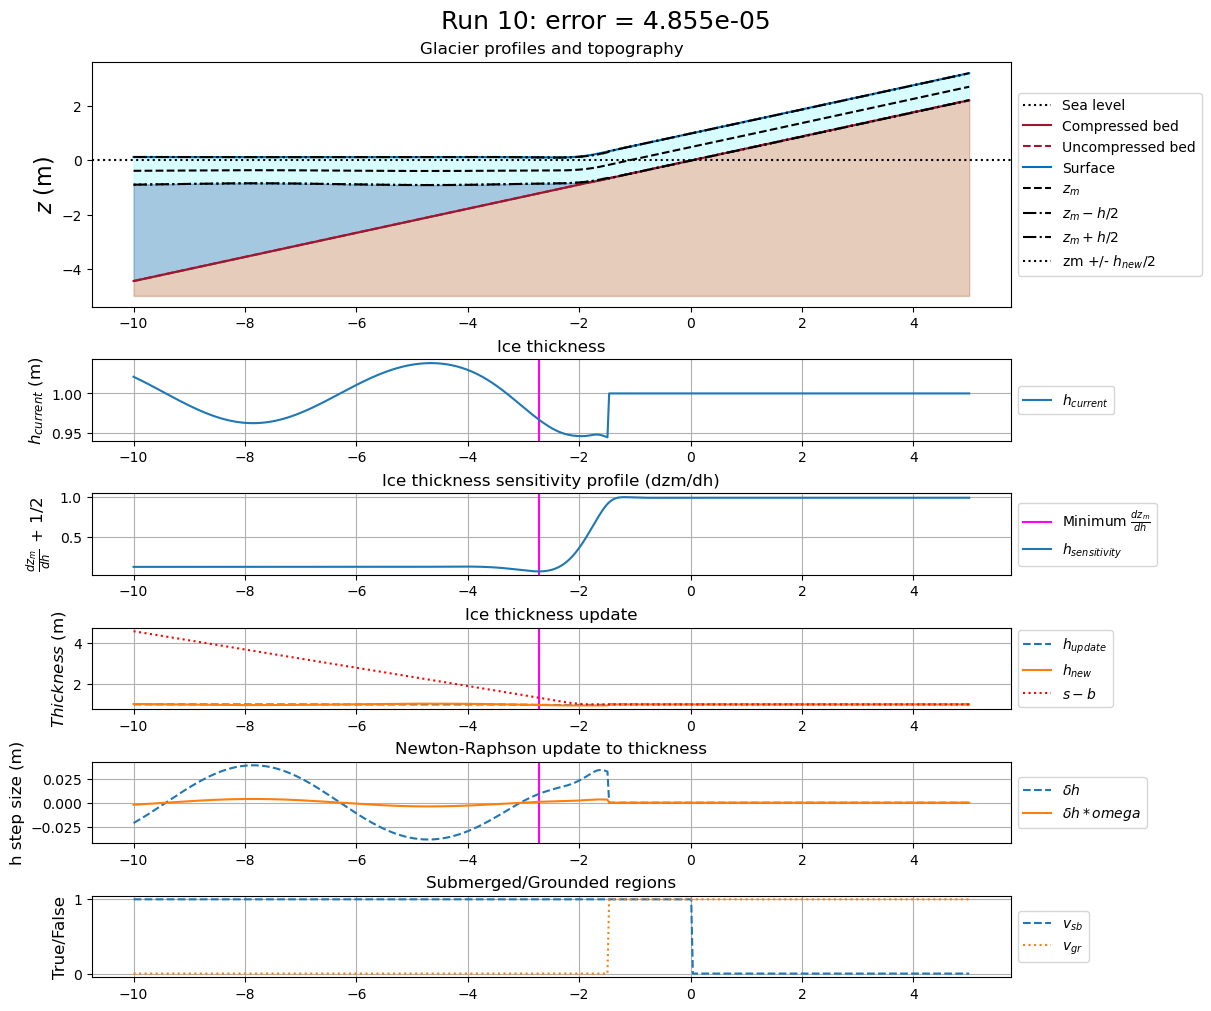

/var/folders/yh/jv903ppx44b04y7xxkd39x3w0000gn/T/ipykernel_29844/4028555671.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


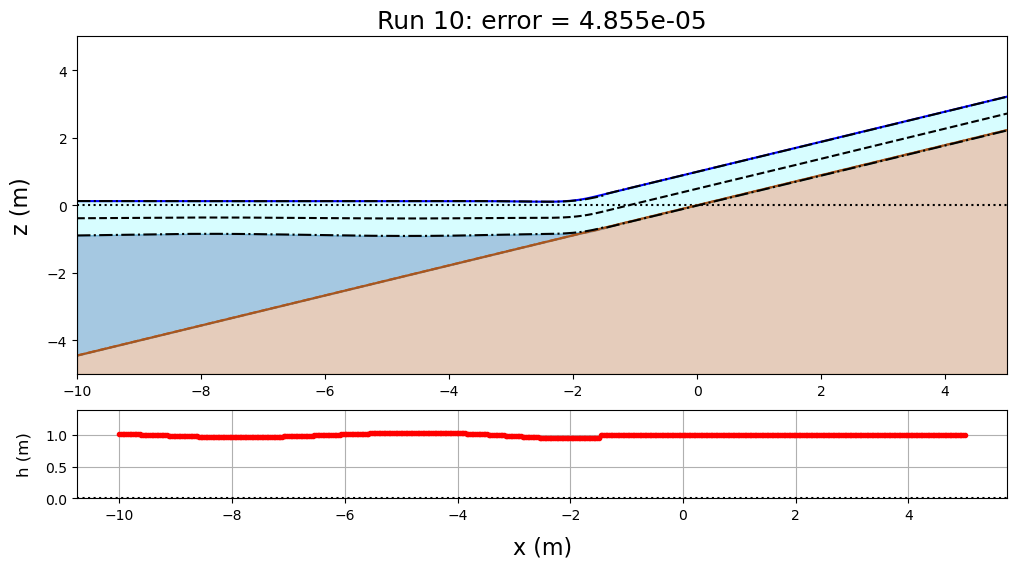

 - Calculated zm
    - run_count = 5
    - Force Residual = 5.760e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 5.332e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 4.933e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 4.560e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 4.215e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 3.895e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 3.598e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 5
    - Force Residual = 3.324e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 6
    - Force Residual = 3.070e-05
 - Calculated dzm_dh
 - Ca

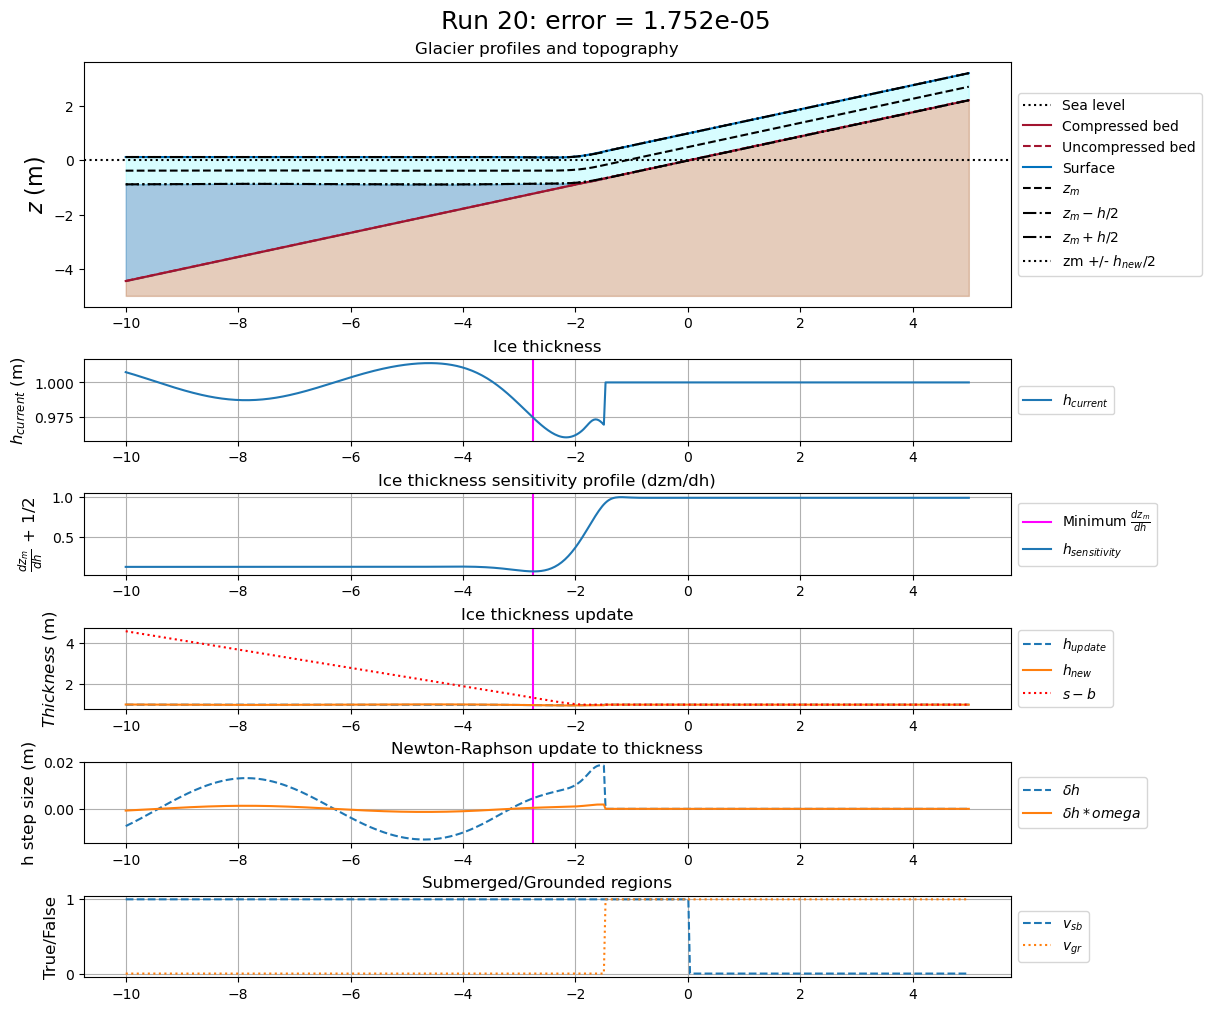

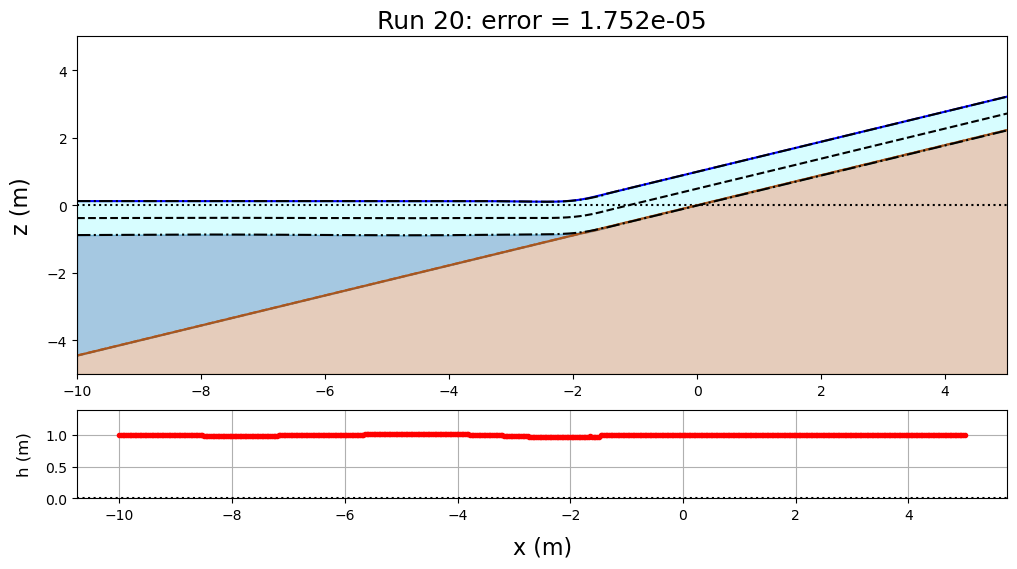

 - Calculated zm
    - run_count = 6
    - Force Residual = 2.618e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 6
    - Force Residual = 2.418e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 6
    - Force Residual = 2.232e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 6
    - Force Residual = 2.060e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 1.901e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 1.755e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 1.619e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 1.493e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 1.376e-05
 - Calculated dzm_dh
 - Ca

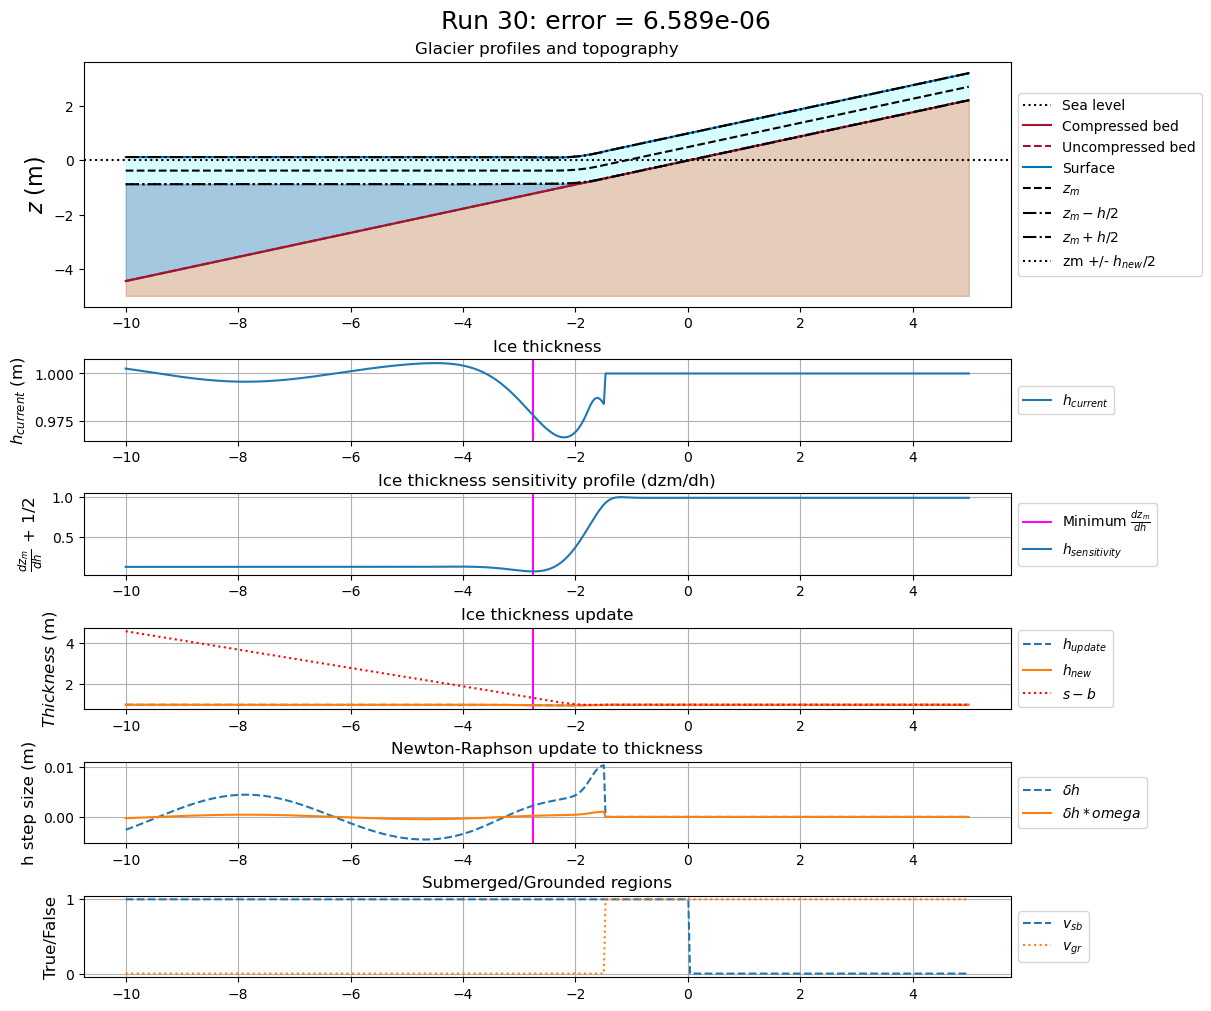

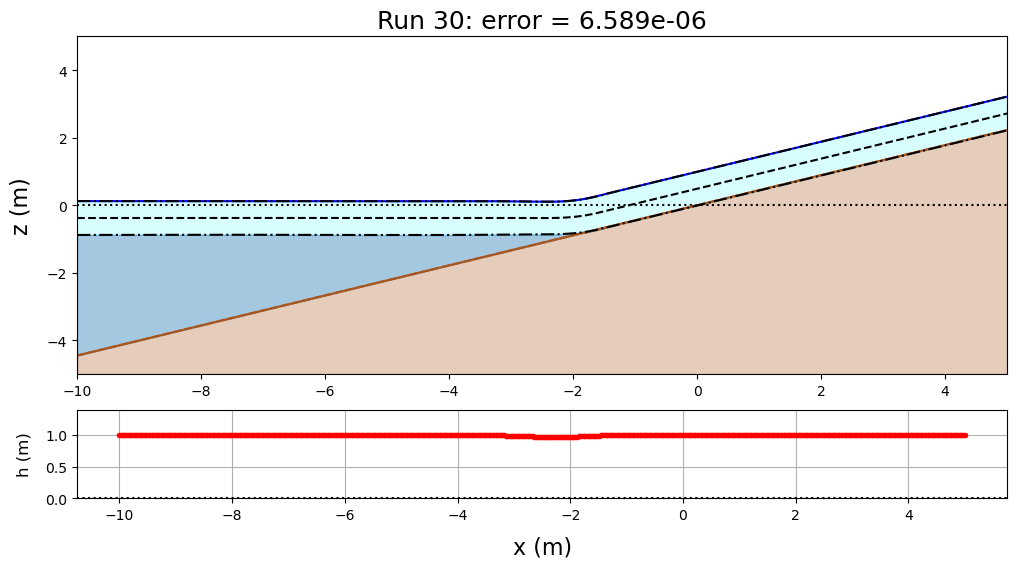

 - Calculated zm
    - run_count = 7
    - Force Residual = 1.169e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 1.077e-05
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 9.919e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 9.130e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 8.403e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 7.731e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 7.110e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 6.536e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 6.009e-06
 - Calculated dzm_dh
 - Ca

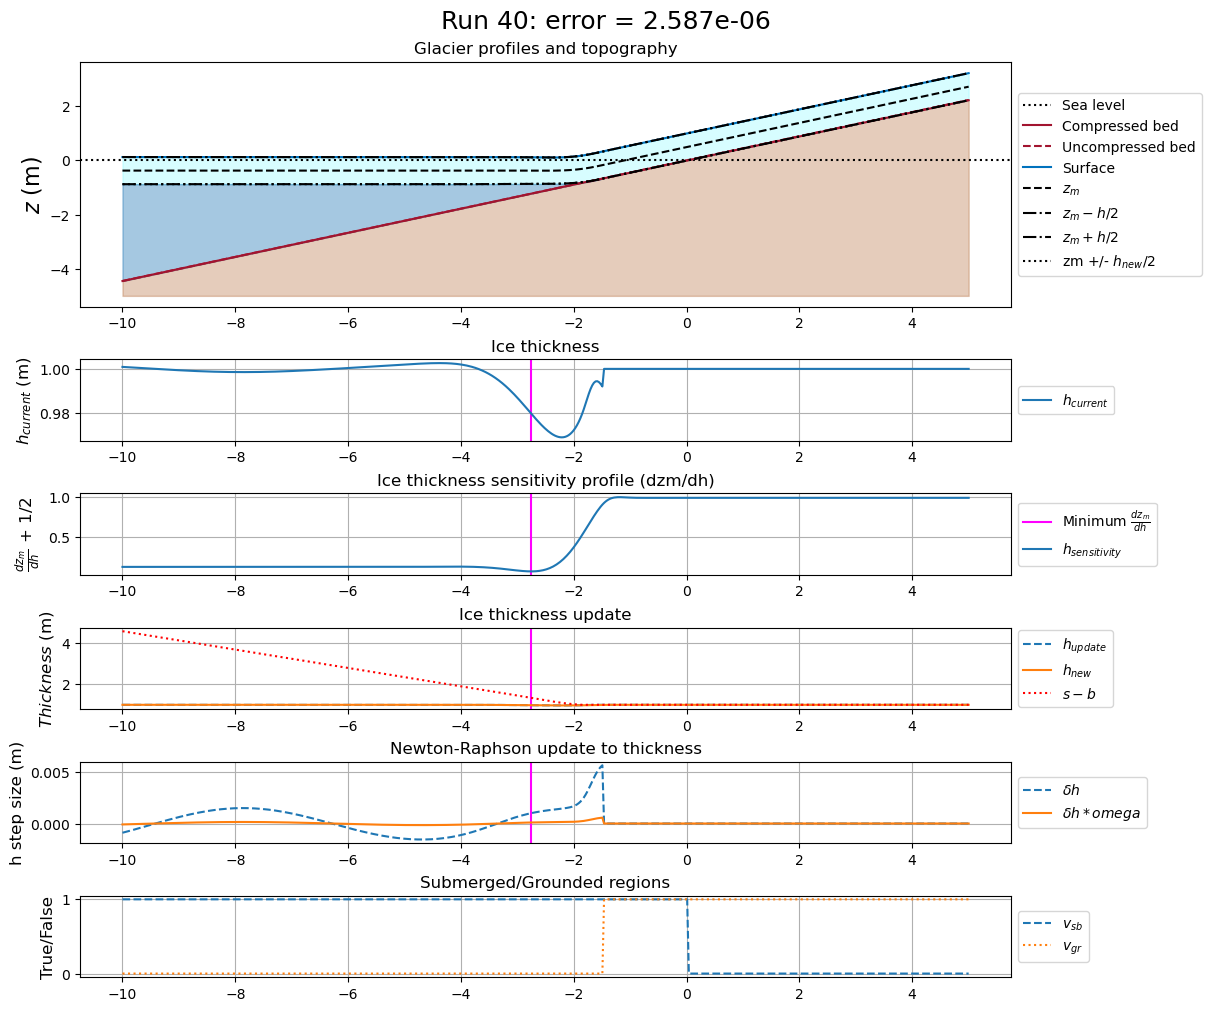

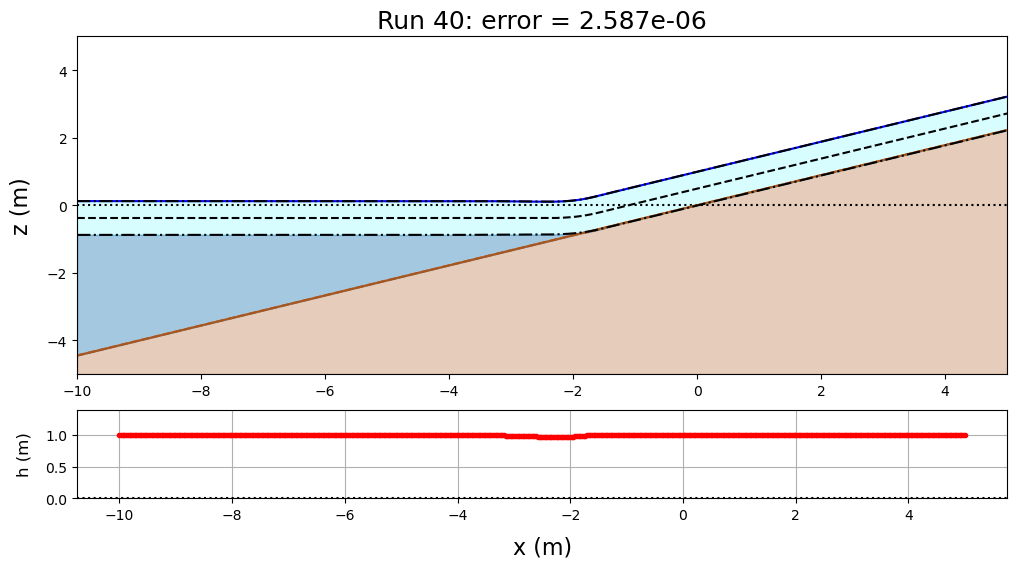

 - Calculated zm
    - run_count = 8
    - Force Residual = 5.073e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 4.658e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 4.278e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 3.924e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 3.600e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 9
    - Force Residual = 3.304e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 3.028e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 2.776e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 2.544e-06
 - Calculated dzm_dh
 - Ca

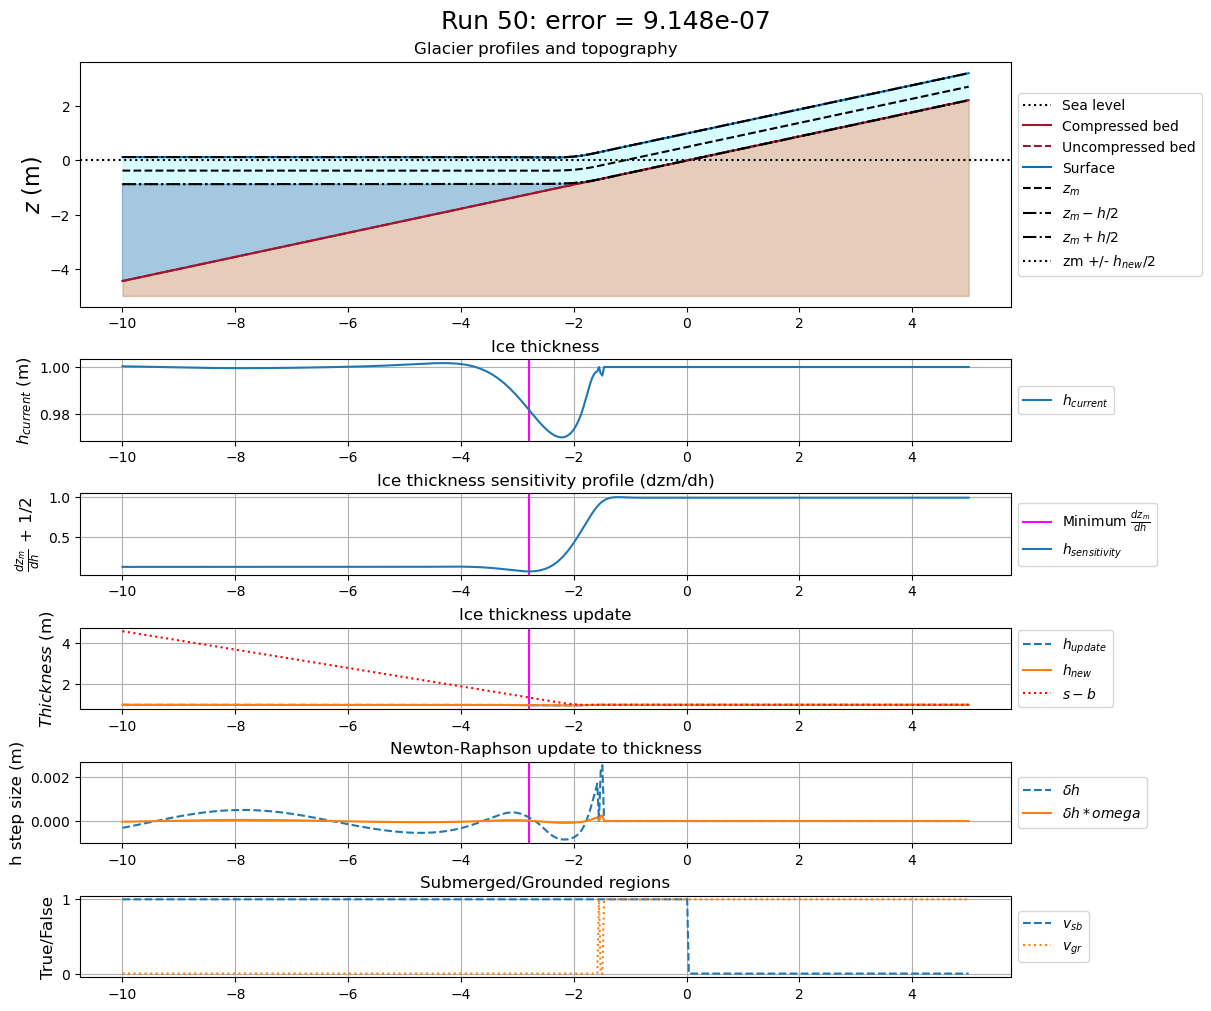

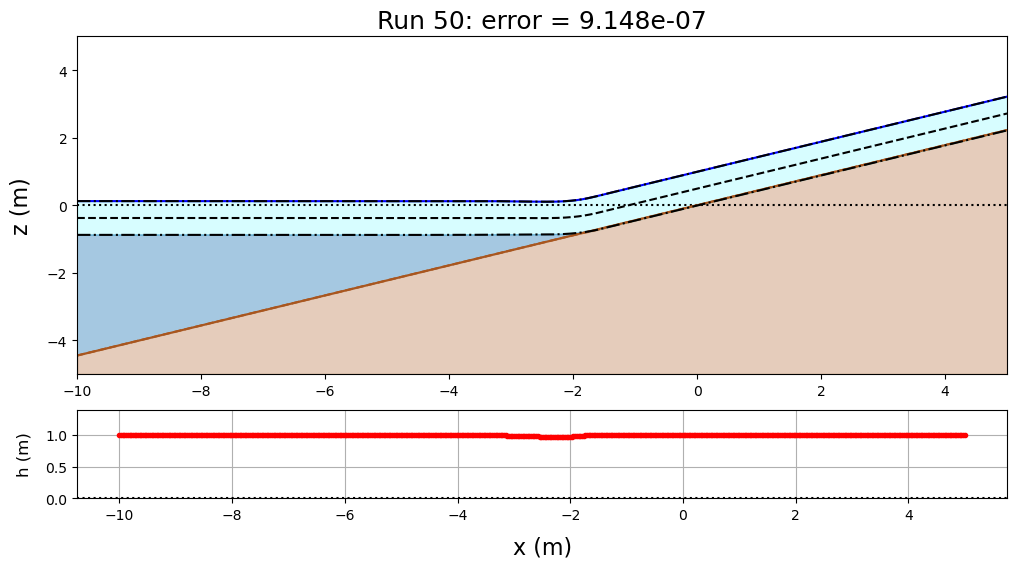

 - Calculated zm
    - run_count = 8
    - Force Residual = 2.138e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 1.957e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 1.791e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 1.642e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 8
    - Force Residual = 1.504e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 1.380e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 1.263e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 1.159e-06
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 3.943e-06
 - Calculated dzm_dh
 - Ca

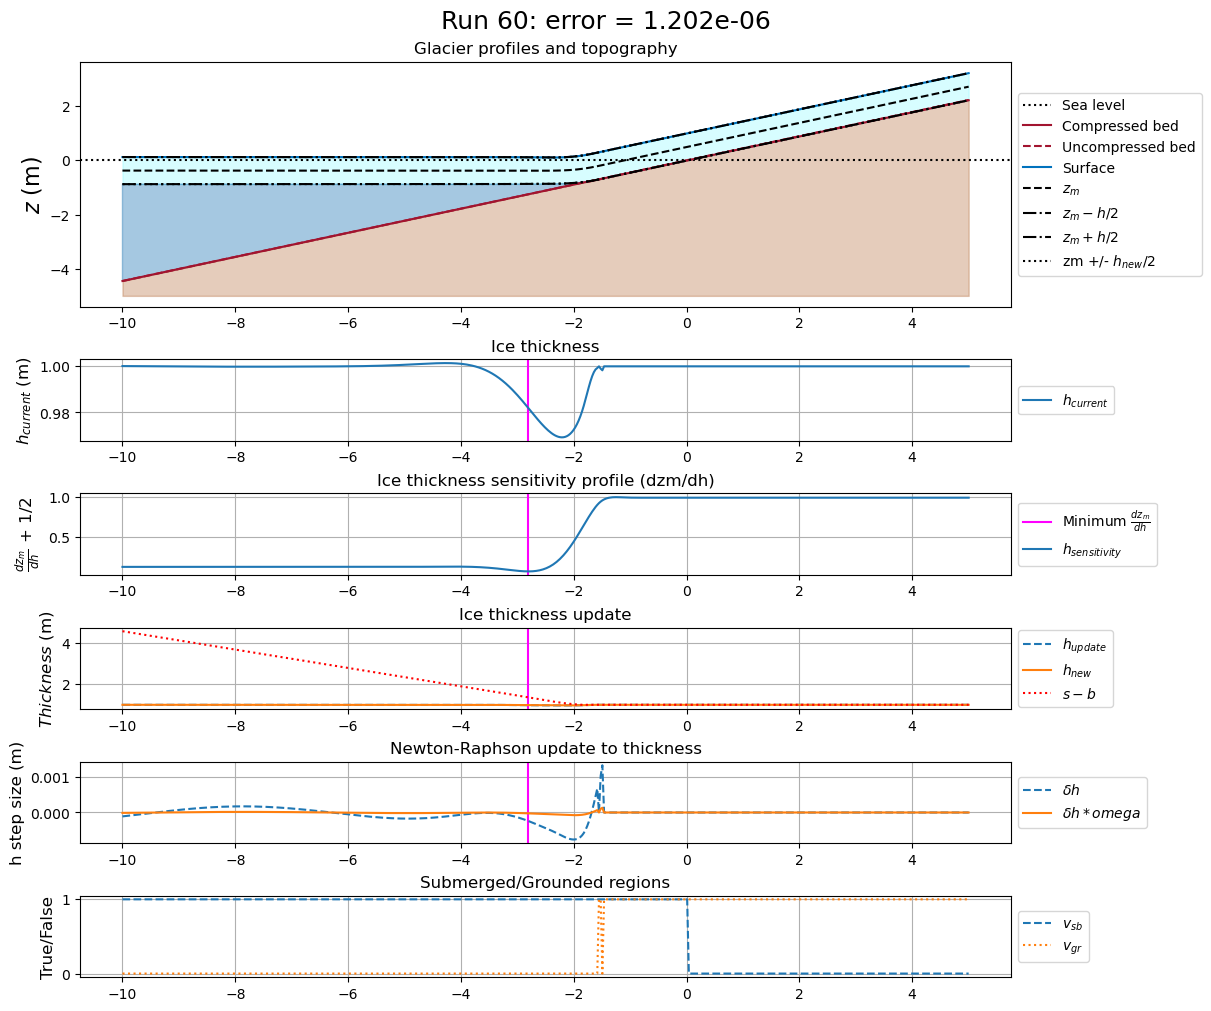

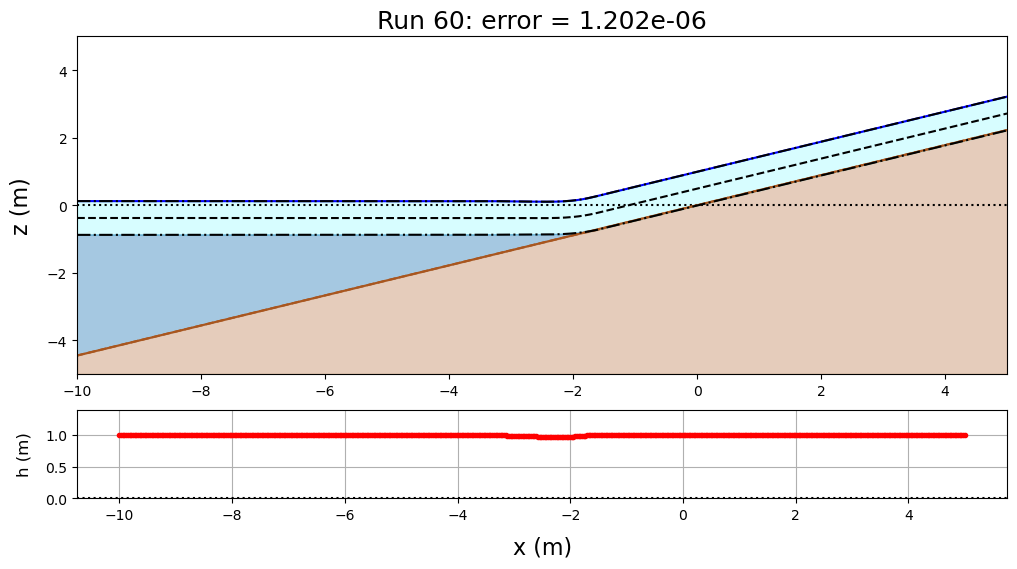

 - Calculated zm
    - run_count = 7
    - Force Residual = 8.876e-07
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 8.125e-07
 - Calculated dzm_dh
 - Calculated dzm_db0
 - Calculated zm
    - run_count = 7
    - Force Residual = 7.454e-07
 - Calculated dzm_dh
 - Calculated dzm_db0


KeyboardInterrupt: 

In [36]:

# Iterative process to determine h(x)
# Parameters for the iteration process
error_threshold = 1e-7
error_val = 10 * error_threshold

# Relaxation parameter
omega_zm = 1
omega_hb = 0.1

h_min = 0.5

max_hb_iter = 1e5
err_s_data = np.zeros(shape=(int(max_hb_iter),1))

quiet = True
force_balance_flag = False

run_count = 1

while (error_val > error_threshold) & (run_count < max_hb_iter):
    
    zm, dzm_dh, dzm_db0 = Flexure_profile_unfixed_grounding_line(zm_init, h_init, b0_init, x, C1, C2, C3, omega_zm, quiet, force_balance_flag)
    
    v_gr = (zm - h/2) <= -b0                                # Grounded region
    v_sb = ((zm - h/2) <= 0) # & ((zm - h/2) > -b0)           # Submerged region

    # Calculate the updated ice thickness (Newton Raphson)

    # h_update = h_init - (zm + h_init/2 - s_data) / (dzm_dh + 1/2)
    # print(h_update, dzm_dh, ((zm + h_init/2 - s_data) / (dzm_dh + 1/2)))
    # h_update = h_init - (zm + h_init/2 - s_data) / (dzm_dh + 1)

    h, h_update = update_profile(h_init , dzm_dh + 1/2, zm + (h_init/2), s, h_data, ~v_gr, omega_hb)
    b0, b0_update = update_profile(b0_init, dzm_db0, zm, zm_data, b_data, v_gr, omega_hb)

    # Avoid negative values of h
    h[h < h_min] = h_min

    error_val = (1/(2*Nx)) * (np.linalg.norm(h_init - h) + np.linalg.norm((b0_init - b0)))

    err_s_data[run_count+1] = (1/(Nx)) * np.linalg.norm(zm + (h/2) - s)

    str_title = 'Run {}: error = {:.3e}'.format(run_count, error_val)
    lgd_flag = 0
    # Plot showing how h is being updated at this stage
    if run_count % 10 == 0:
        h_update_plot(x, s, b_data, b0, zm, h_init, h_update, h, dzm_dh, omega_hb, lgd_flag, str_title)

    # Plot the results of the current iteration
    if (run_count % 10 == 0):
        str_title = f'Run {run_count}: error = {error_val:.3e}'
        ice_profile(x, s, b, zm, h, b0, dzm_dh, lgd_flag, str_title)

    # Update profiles for the next loop
    h_init = h.copy()
    b0_init = b0.copy()

    run_count += 1
    # print(f"-- Run {run_count}: error = {error_val:.3e} --")

str_title = f'Final profile: error = {error_val:.3e}'
ice_profile(x, s, b, zm, h, b0, dzm_dh, lgd_flag, str_title)


v_gr = (zm - h/2) <= -b0        # grounded region
v_ungr = (zm - h/2) > -b0        # ungrounded region
v_sb = ((zm - h/2) <= 0) & v_gr # submerged region
v_flt = v_sb & v_ungr           # submerged and ungrounded

idxs_gr = contiguous_regions(v_gr)
# idxs_sb = contiguous_regions(v_sb)
idxs_flt = contiguous_regions(v_flt)


finalplots(idxs_gr, idxs_flt, zm, b0, x)


In [ ]:
# Plot calculated profile
'''
# fig, ax = plt.subplots(figsize=(15, 8), tight_layout=True)

# ax.axvline(-ug, color='k', linestyle='--', alpha=0.1)  # xline
# ax.axvline(-ug, color='k', linestyle='--', alpha=0.1)
# ax.axhline(0, color='k', linestyle=':') 

# for start, end in idxs_gr:
#     ax.fill_between(x[start:end], -b[start:end], zm[start:end]+h[start:end]/2, interpolate=True, facecolor='b', alpha=0.15)

# # Submerged regions (uncomment if required)
# # for start, end in idxs_sb:
# #     ax.fill_betweenx([min(-b), max(zm + h / 2)], x[start], x[end], facecolor='r', alpha=0.05)

# # Floating regions
# for start, end in idxs_flt:
#     ax.fill_between(x[start:end], -b[start:end], zm[start:end]+h[start:end]/2, interpolate=True, facecolor='g', alpha=0.15)

# # Plot main profiles
# handle_za, = ax.plot(x, za, 'm-', linewidth=1.5, label='Analytical solution')
# ax.plot(x, za - H / 2, 'm')  # Analytical bounds
# ax.plot(x, za + H / 2, 'm')

# handle_zm, = ax.plot(x, zm, 'b--', linewidth=1.5, label='Numerical solution')
# ax.plot(x, zm - h / 2, 'b:')  # Numerical bounds
# ax.plot(x, zm + h / 2, 'b:')

# handle_b, = ax.plot(x, -b, 'r-', label='Bed topography')
# ax.plot(x, -b0, 'r--', label='Bed topography')


# # Final plot settings
# ax.set_box_aspect(1/3)  # Box on equivalent
# ax.set_xlabel(f'$x$ (m)', fontsize=16)
# ax.set_ylabel(f'$z$ (m)', fontsize=16)
# ax.set_xlim(-10, 10)
# ax.set_ylim(-3, 3)

# # ax.set_xlim(-3, 0)
# # ax.set_ylim(-2, 2)

# ax.set_title(f"S = tan({(base_angle * (180 / np.pi)):.2g}{u'\N{DEGREE SIGN}'}), E = {E_ice:.2g}Pa, $k_i$/$\\rho_i$g = {(k0 / (rho_i * g)):.2g}, Nx = {Nx}", fontsize=20, pad=20)

# # Legend
# ax.legend(handles=[handle_b, handle_zm, handle_za], fontsize=14, loc='lower center', ncol=3, bbox_to_anchor=[0.5, -0.4])

# # Inset - Grounding-line region
# inset_ax = fig.add_axes([0.7, 0.4, 0.25, 0.2])  # Equivalent to 'Position',[0.6,0.25,0.25,0.2]
# inset_ax.axvline(-ug, color='k', linestyle='--')
# inset_ax.axhline(0, color='k', linewidth=0.5)

# # Inset profiles
# inset_ax.plot(x, za, 'm-', linewidth=1.5)
# inset_ax.plot(x, za - h / 2, 'm')
# inset_ax.plot(x, za + h / 2, 'm')
# inset_ax.plot(x, zm, 'b--', linewidth=1.5)
# inset_ax.plot(x, zm - h / 2, 'b:')
# inset_ax.plot(x, zm + h / 2, 'b:')
# inset_ax.plot(x, -b, 'r-')

# # Final inset settings
# inset_ax.set_xlim(-ug + L * np.array([-6, 6]))
# inset_ax.set_ylim(-1.5, 1.5)  # Uncomment if needed
# inset_ax.set_box_aspect(1/2)

# plt.show()


# fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

# ax.plot(x, zm - za, 'k-', linewidth=1.5, label='Difference (zm-za)')
# ax.set_xlabel(f'$x$ (m)', fontsize=16)
# ax.set_ylabel(f'$z$ (m)', fontsize=16)
# # ax.set_xlim(-40, 40)
# ax.set_title('Difference between numerical and analytical solutions', fontsize=16)
# ax.legend(fontsize=14, loc='lower center', bbox_to_anchor=[0.5, -0.4])

# plt.show()

# fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

# ax.plot(x, h, 'r-', linewidth=1.5, label='Thickness')
# ax.set_xlabel(f'$x$ (m)', fontsize=16)
# ax.set_ylabel(f'$h$ (m)', fontsize=16)
# # ax.set_xlim(-40, 40)
# ax.set_title('Thickness of sheet produced in numerical solution', fontsize=16)
# ax.legend(fontsize=14, loc='lower center', bbox_to_anchor=[0.5, -0.4])

# plt.show()

# fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

# ax.plot(x, 100 * (h-1)/1, 'r-', linewidth=1.5, label='Thickness')

# ax.set_xlabel(f'$x$ (m)', fontsize=16)
# ax.set_ylabel(f'$\delta h/h$ (%)', fontsize=16)
# # ax.set_xlim(-40, 40)
# ax.set_title('Fractional error in thickness produced by numerics', fontsize=16)
# ax.legend(fontsize=14, loc='lower center', bbox_to_anchor=[0.5, -0.4])

# plt.show()
'''

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/yh/jv903ppx44b04y7xxkd39x3w0000gn/T/ipykernel_29844/898977770.py:2: SyntaxWarning: invalid escape sequence '\d'
  '''


'\n# fig, ax = plt.subplots(figsize=(15, 8), tight_layout=True)\n\n# ax.axvline(-ug, color=\'k\', linestyle=\'--\', alpha=0.1)  # xline\n# ax.axvline(-ug, color=\'k\', linestyle=\'--\', alpha=0.1)\n# ax.axhline(0, color=\'k\', linestyle=\':\') \n\n# for start, end in idxs_gr:\n#     ax.fill_between(x[start:end], -b[start:end], zm[start:end]+h[start:end]/2, interpolate=True, facecolor=\'b\', alpha=0.15)\n\n# # Submerged regions (uncomment if required)\n# # for start, end in idxs_sb:\n# #     ax.fill_betweenx([min(-b), max(zm + h / 2)], x[start], x[end], facecolor=\'r\', alpha=0.05)\n\n# # Floating regions\n# for start, end in idxs_flt:\n#     ax.fill_between(x[start:end], -b[start:end], zm[start:end]+h[start:end]/2, interpolate=True, facecolor=\'g\', alpha=0.15)\n\n# # Plot main profiles\n# handle_za, = ax.plot(x, za, \'m-\', linewidth=1.5, label=\'Analytical solution\')\n# ax.plot(x, za - H / 2, \'m\')  # Analytical bounds\n# ax.plot(x, za + H / 2, \'m\')\n\n# handle_zm, = ax.plot(x, z

(0.0, 1e-09)

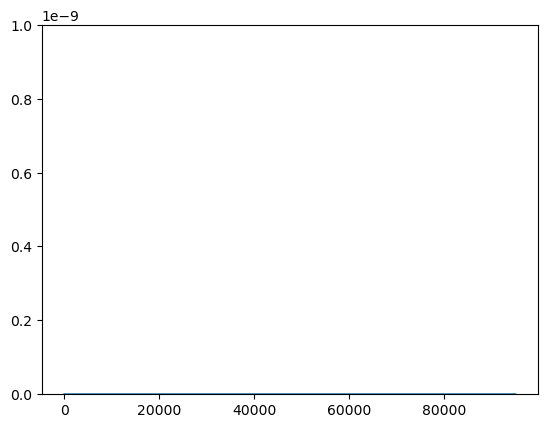

In [ ]:
plt.plot(err_s_data[5000:])
plt.ylim(0,1e-9)

In [ ]:

# v_gr = (zm - h/2) <= -b0        # grounded region
# v_ungr = (zm - h/2) > -b0        # ungrounded region
# v_sb = ((zm - h/2) <= 0) & v_gr # submerged region
# v_flt = v_sb & v_ungr           # submerged and ungrounded


# # Force balances

# Elastic_force = 

# Loading_force = rho_i * g * h

# Buoyancy_force = h[v_ungr]

# Normal_force = 





# fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

# ax.plot(x, 100 * (h-1)/1, 'r-', linewidth=1.5, label='Thickness')

# ax.set_xlabel(f'$x$ (m)', fontsize=16)
# ax.set_ylabel(f'$\delta h/h$ (%)', fontsize=16)
# # ax.set_xlim(-40, 40)
# ax.set_title('Fractional error in thickness produced by numerics', fontsize=16)
# ax.legend(fontsize=14, loc='lower center', bbox_to_anchor=[0.5, -0.4])

# plt.show()